In [18]:
import json
import math
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.spatial import Delaunay
from matplotlib.pyplot import figure
from shapely.geometry import mapping, shape, MultiPoint, Point
from shapely.ops import triangulate


In [19]:
# Info: 
# GeoJson: [lng, lat]
# x y ~ lng lat

In [59]:
# Load geojson
# Define locations
filename = "cities_pop_3000000.geojson"
    
with open(filename) as f:
    gj = json.load(f)
    points = MultiPoint([
        (feat['geometry']['coordinates'][0], feat['geometry']['coordinates'][1])
        for feat in gj['features']
    ])
    gs_points = gpd.GeoSeries([
        Point(feat['geometry']['coordinates'][0], feat['geometry']['coordinates'][1])
        for feat in gj['features']
    ])
    
print("Loaded " + str(len(gs_points)) + " city coordinates")

Loaded 240 city coordinates


In [64]:
def get_haversine_distance(p1, p2):
    R = 6373.0
    lat1 = math.radians(p1.y)
    lon1 = math.radians(p1.x)
    lat2 = math.radians(p2.y)
    lon2 = math.radians(p2.x)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    # kilometer     
    return distance


def get_lowest_centroid_distance(polygon, mode="normal", measure="min"):
    pc = polygon.centroid
    distances = []
    result = 0;

    if mode == "hausdorf":
        # Not working yet
        result = polygon.hausdorff_distance(pc)
    elif mode == "haversine":        
        for coords in np.array(polygon.boundary.coords):
            p1 = Point(coords)
            distances.append(get_haversine_distance(p1, pc))               
    else:
        for coords in np.array(polygon.boundary.coords):
            p1 = Point(coords)
            distances.append(p1.distance(pc))
                
    if measure == "min":
        return np.sort(distances)[0]
    elif measure == "avg":
        return sum(distances) / len(distances)
    else:
        return 0


def get_farthest_point(points, mode="delaunay", show=True):
    # triangulate geo_points
    triangles = triangulate(points)
    centroid_distances = []

    for idx, poly in enumerate(triangles):
        # plot triangles and centroids
        centroid_distances.append([idx, get_lowest_centroid_distance(poly, mode="normal")])

        # plot triangles and centroids
        if show:
            x,y = poly.exterior.xy
            plt.plot(poly.centroid.x, poly.centroid.y, 'ro')
            plt.plot(x,y)

    highest_distance_idx = sorted(centroid_distances, key=lambda x: x[1], reverse=True)[0]
    highest_distance_centroid = triangles[highest_distance_idx[0]].centroid

    if show:
        plt.plot(highest_distance_centroid.x, highest_distance_centroid.y, 'bo')
    
    return highest_distance_centroid

lng lat of highest dinstance point: POINT (64.79682193333333 -33.86834486666667)
https://www.google.com/maps/search/?api=1&query=-33.868344866666675,64.79682193333333


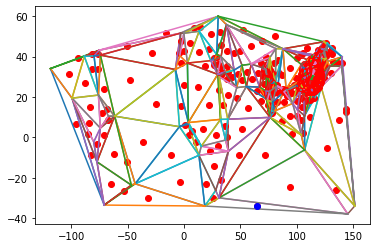

In [65]:
hdc = get_farthest_point(points)

print("lng lat of highest dinstance point: " + str(hdc))
print("https://www.google.com/maps/search/?api=1&query=" + str(hdc.y) + "," + str(hdc.x))

In [66]:
# display points on map
url = gpd.datasets.get_path('naturalearth_lowres')
df = gpd.read_file(url)
crs_projection = "EPSG:4326"


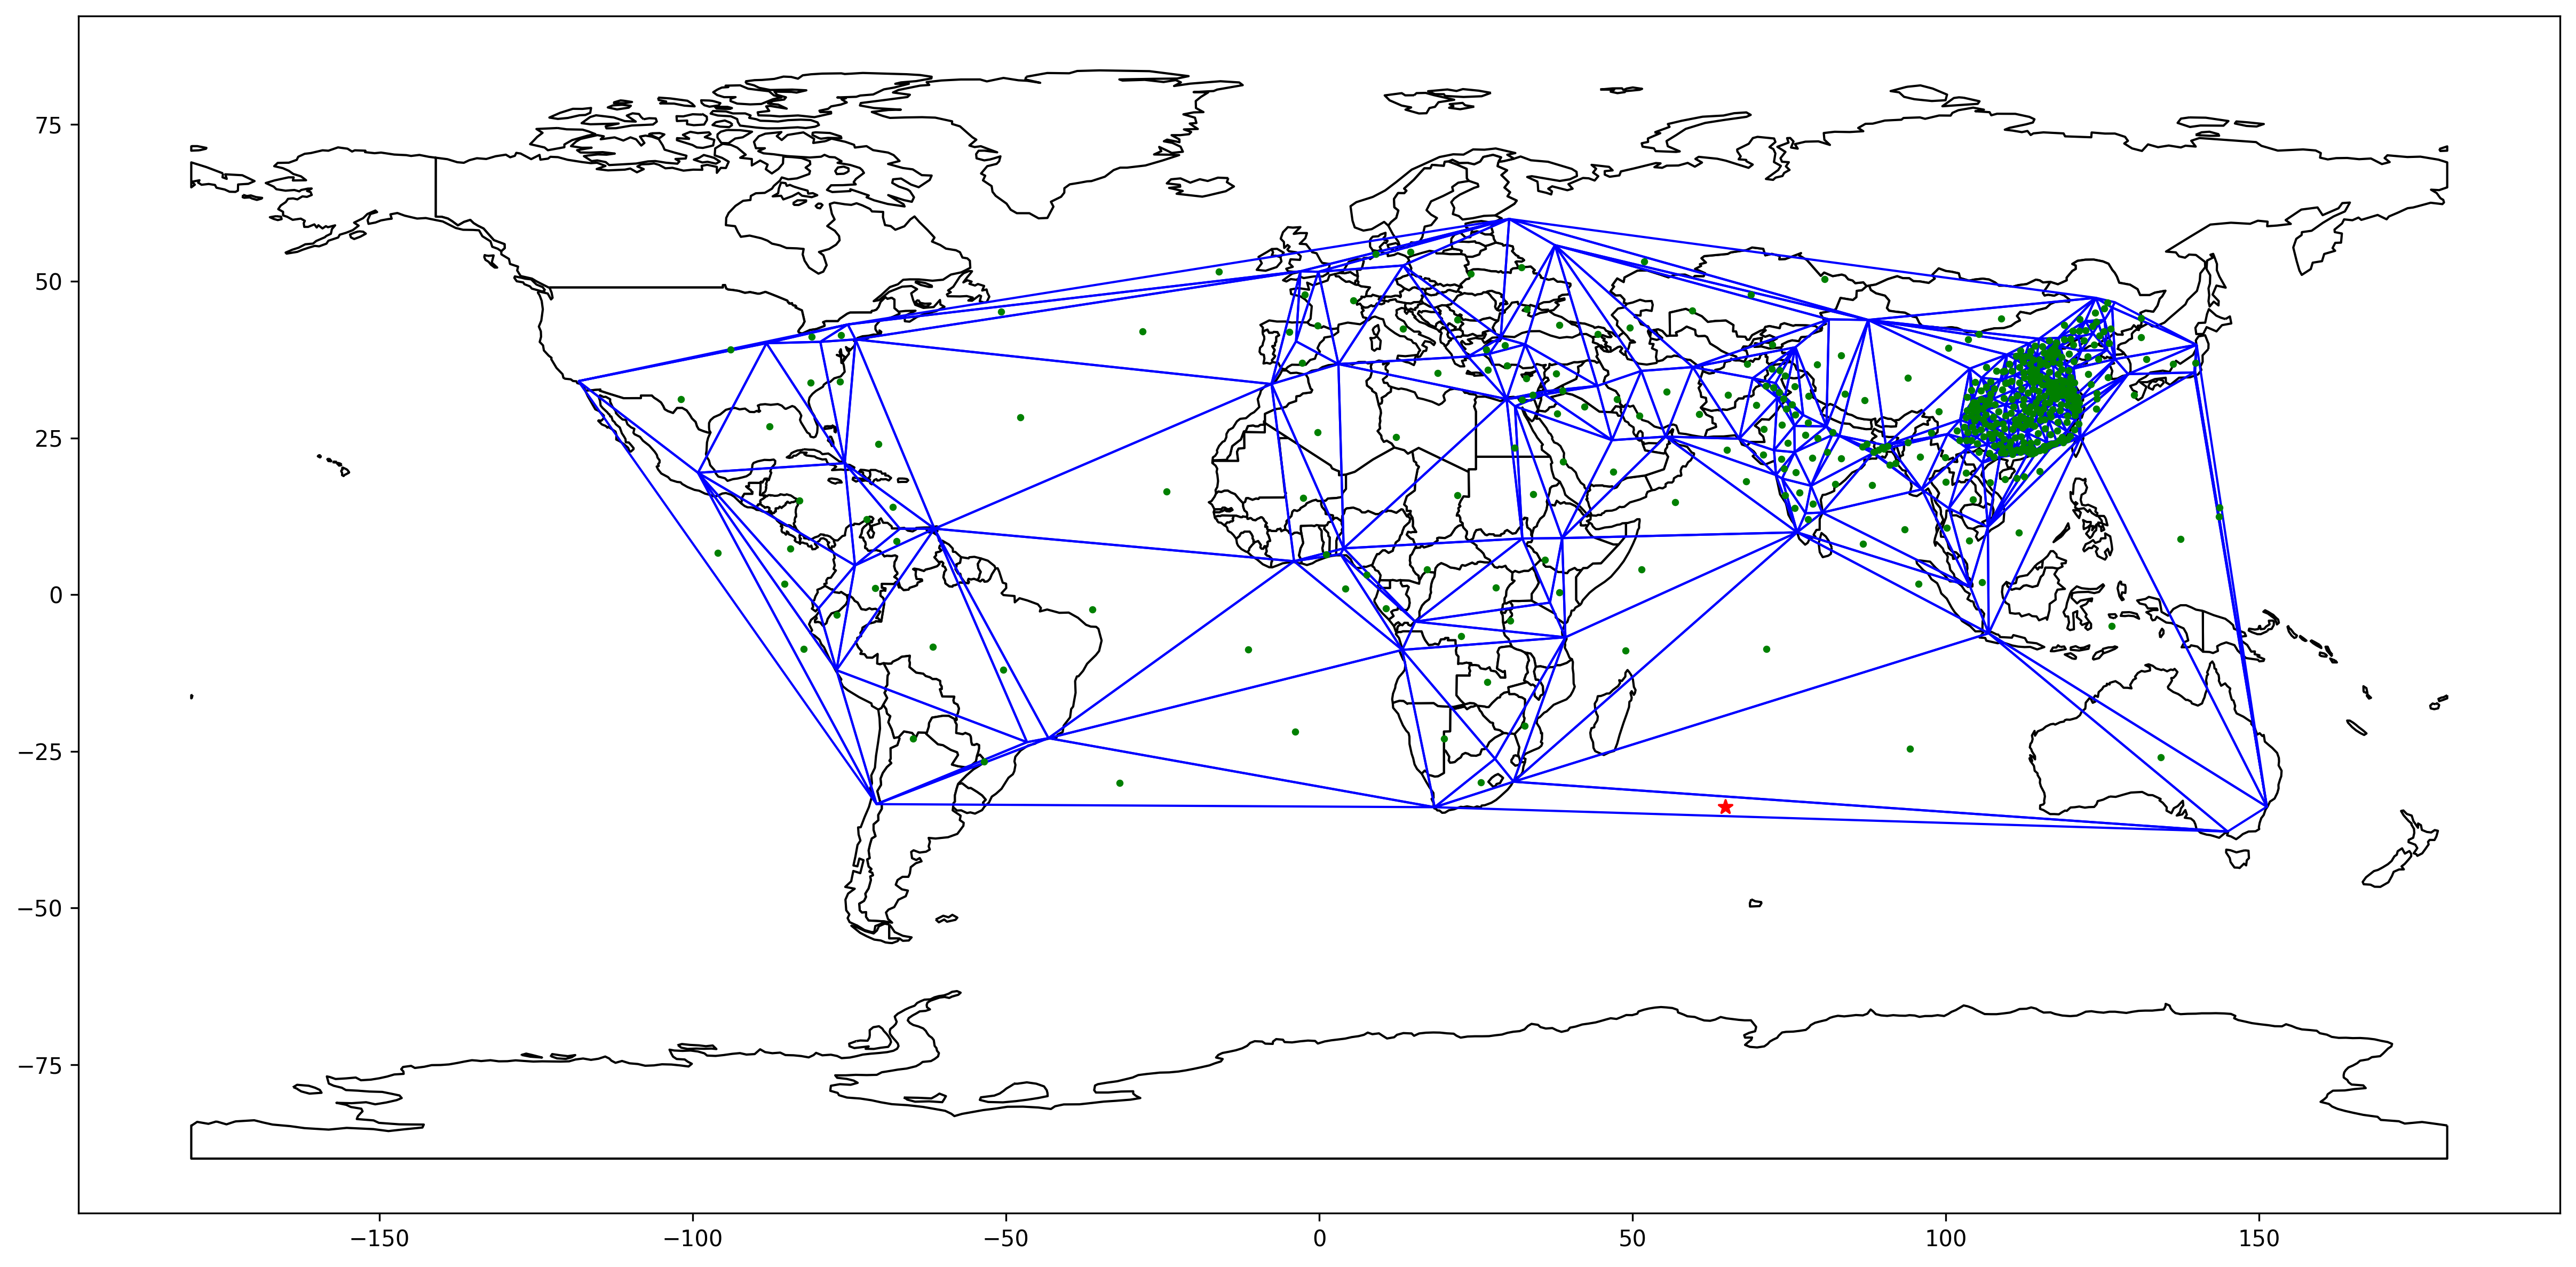

In [67]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300)
ax.set_aspect('equal')

df.plot(ax=ax, color='white', edgecolor='black')

gs_triangles = gpd.GeoSeries(triangulate(points))
gs_triangles.plot(ax=ax, color='none', edgecolor='blue')

gs_centroid = gpd.GeoSeries(Point(poly.centroid.x, poly.centroid.y) for idx, poly in enumerate(triangulate(points)))
gs_centroid.plot(ax=ax, marker='.', color='green', markersize=20)

gs_hdp = gpd.GeoSeries(Point(hdc.x, hdc.y))
gs_hdp.plot(ax=ax, marker='*', color='red', markersize=40)

plt.show();